In [31]:
import numpy as np
import pandas as pd
import yahoo_fin.stock_info as si
import get_all_tickers.get_tickers as gt
import yfinance as yf
import json
import datetime

In [32]:
price_data = pd.read_csv("../stock_price_data_from_2016.csv", index_col=0)
fundamental_data = pd.read_csv("../relevant_fundamentals.csv", index_col=0)
funds = pd.read_csv("../fundamentals.csv", index_col=0)
price_data["date"] = price_data.index
test_df = price_data[price_data.ticker == "MSFT"]


### write functions

In [33]:
def get_funds_date(date, ticker):
    # first check if there is a date before the starting date of the analysis
    ticker_funds = funds[funds.ticker == ticker]
    ticker_funds = ticker_funds.sort_values(by = "date", ascending = False)
    for date in ticker_funds.date:
        if date < start_date:
            
            day = int(date[-2:])
            month = int(date[-5:-3])
            year = int(date[:4])
            date = datetime.date(year,month,day)
            date = date.strftime("%Y-%m-%d")
            return date
    return np.nan
            
        

def get_correct_date(date, test_df):
    day = int(date[:2])
    month = int(date[3:5])
    year = int(date[-4:])
    date = datetime.date(year,month,day)
    date = date.strftime("%Y-%m-%d")
    while len(test_df[test_df.date == date]) == 0:
        if month == 12 and day == 31:
            year += 1
            day = 1
            month = 1
            date = datetime.date(year,month,day)
            date = date.strftime("%Y-%m-%d")

        else:
            try:
                day += 1
                date = datetime.date(year,month,day)
                date = date.strftime("%Y-%m-%d")

            except:
                month += 1
                day = 1
                date = datetime.date(year,month,day)
                date = date.strftime("%Y-%m-%d")
    return date

### Set date of the analysis

In [34]:
start_date = "01.02.2019" # this is how a user would input the date
end_date = "01.02.2020"
start_date = get_correct_date(start_date, test_df)
end_date = get_correct_date(end_date, test_df)
start_date_data = price_data[price_data.date == start_date]

#### This function computes the variables date for all tickers

funds_dates = []
funds_ticker = []
funds_at = []
funds_op = []
funds_so = []
prices = []
for ticker in funds.ticker.unique():
    
    rel_date = get_funds_date(start_date, ticker)
    try:
        funds_at.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["at"].item())
    except:
        funds_at.append(np.nan)
    try:
        funds_op.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["op"].item())
    except:
        funds_op.append(np.nan)
    try:
        funds_so.append(funds[(funds.date == rel_date) & (funds.ticker == ticker)]["so"].item())
    except:
        funds_so.append(np.nan)
    try:
        prices.append(start_date_data[start_date_data.ticker == ticker]["adjclose"].item())
    except:
        prices.append(np.nan)
    
    funds_dates.append(rel_date)
    funds_ticker.append(ticker)
    
fund_df = pd.DataFrame({
    "ticker" : funds_ticker,
    "date" : funds_dates,
    "at" : funds_at,
    "op" : funds_op,
    "so" : funds_so,
    "adjclose" : prices
})

fund_df


### Add new variables

# market value
fund_df["mar_cap"] = fund_df.so * fund_df.adjclose

# book-to-market
fund_df["beme"] = fund_df["at"]/fund_df["mar_cap"]

# op to at
fund_df["prof"] = fund_df["op"]/fund_df["at"]

### Now compute the momentum

In [35]:
# two dataframes
start_price = price_data[price_data.date == start_date]
end_price = price_data[price_data.date == end_date]

In [36]:
momentum_list = []
mom_ticker_list = []
for ticker in start_price.ticker:
    try:
        date_price = start_price[start_price.ticker == ticker][:1]["adjclose"].item()
        today_price = end_price[end_price.ticker == ticker][:1]["adjclose"].item()
        momentum = today_price - date_price
        momentum_list.append(momentum)
        mom_ticker_list.append(ticker)
    except:
        pass

In [37]:
df = pd.DataFrame({
    "ticker" : mom_ticker_list,
    "momentum" : momentum_list
})

df = df.sort_values(by = "momentum", ascending = False)
df.reset_index(drop = True, inplace = True)
momentum_stocks = df[:50]["ticker"].to_list()

value_stocks_df = fund_df.sort_values(by = "beme", ascending = False)
profit_stocks_df = fund_df.sort_values(by = "op", ascending = False)

value_stocks_df = value_stocks_df[value_stocks_df.ticker.isin(trading_212_tickers)]
value_stocks_df.reset_index(drop = True, inplace = True)
profit_stocks_df = profit_stocks_df[profit_stocks_df.ticker.isin(trading_212_tickers)]
profit_stocks_df.reset_index(drop = True, inplace = True)

value_stocks = value_stocks_df[:15]["ticker"].to_list()

profit_stocks = profit_stocks_df[:15]["ticker"].to_list()

print(momentum_stocks, value_stocks, profit_stocks)

In [38]:
import pandas as pd
import random
import yahoo_fin.stock_info as si
import yfinance as yf
import json
import csv
import re
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import get_all_tickers.get_tickers as gt
from lxml import html
import matplotlib.pyplot as plt
import json

## Scrape Sector and Country to diversify

Create Dataframes

In [39]:
# get a list of all countries

with open("../countries.json", "r") as f:
    countries = json.load(f)

1. Value Stocks

name_list = []

for ticker in value_stocks:
    try:
        url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url_shares_outstanding.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in value_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in value_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

value_df = pd.DataFrame({
    "ticker" : value_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

2. Momentum Stocks

In [40]:
name_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        info[0].text
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in momentum_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

momentum_df = pd.DataFrame({
    "ticker" : momentum_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

In [41]:
momentum_df = momentum_df.dropna(how = "any")

3. Profit Stocks

name_list = []

for ticker in profit_stocks:
    try:
        url_shares_outstanding = "https://finance.yahoo.com/quote/{}/key-statistics?p={}"
        response = requests.get(url_shares_outstanding.format(ticker, ticker))        
        soup = bs(response.text, "html.parser")
        pattern = re.compile(r"\s--\sData\s--\s")
        script_data = soup.find("script", text = pattern).contents[0]
        start = script_data.find("context")-2
        json_data = json.loads(script_data[start:-12])
        short_name = json_data["context"]["dispatcher"]["stores"]["QuoteSummaryStore"]["quoteType"]["shortName"]
        name_list.append(short_name)
    except:
        name_list.append(np.nan)

country_list = []

for ticker in profit_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"

        r = requests.get(url.format(ticker, ticker))
        soup = bs(r.content)
        info = soup.find_all("p", attrs = {"class", "D(ib) W(47.727%) Pend(40px)"})
        info[0].text
        for c in countries:
            if c in info[0].text:
                country_list.append(c)
                break
    except:
        country_list.append(np.nan)

industry_list = []

for ticker in profit_stocks:
    try:
        url = "https://finance.yahoo.com/quote/{}/profile?p={}"
        response = requests.get(url.format(ticker, ticker))        
        soup = bs(response.text, "lxml")

        industry = soup.find_all("span", {"class" : "Fw(600)"})[0].text
        industry_list.append(industry)
    except:
        industry_list.append(np.nan)

profit_df = pd.DataFrame({
    "ticker" : profit_stocks,
    "names" : name_list,
    "industry" : industry_list,
    "country" : country_list

})

# Now lets form a diversified Portfolio

### It should consist of 10-15 stocks, diversified over industry and country

In [42]:
portfolio_df = pd.DataFrame(columns=["ticker", "names", "industry", "country"])
index = 0
mom = 0
val = 0
pro = 0
origin_list = [] # list for the origins of the stocks
c_list = []
i_list = []

while (len(portfolio_df) < 15) & (index < 50):
    
    try:
        if momentum_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(momentum_df.loc[index]["country"]) < 5 and i_list.count(momentum_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(momentum_df.loc[index])
            c_list.append(momentum_df.loc[index]["country"])
            i_list.append(momentum_df.loc[index]["industry"])
            #mom += 1
            origin_list.append("mom")
            index += 1
        else:
            index += 1
    except:
        index += 1
portfolio_df["origin"] = origin_list


            
            

            

        
            
        elif val <= 3 and value_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(value_df.loc[index]["country"]) < 5 and i_list.count(value_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(value_df.loc[index])

            c_list.append(value_df.loc[index]["country"])
            i_list.append(value_df.loc[index]["industry"])
            val += 1
            origin_list.append("val")
        
            
        elif pro <= 3 and profit_df.loc[index]["names"] not in portfolio_df.names.to_list() and c_list.count(profit_df.loc[index]["country"]) < 5 and i_list.count(profit_df.loc[index]["industry"]) < 2:
            
            portfolio_df = portfolio_df.append(profit_df.loc[index])

            c_list.append(profit_df.loc[index]["country"])
            i_list.append(profit_df.loc[index]["industry"])
            pro += 1
            origin_list.append("pro")
        else:
            index += 1
        
        
    except:
        index += 1
    
portfolio_df["origin"] = origin_list
    

### Check if there are NaN adjusted closes

In [43]:
portfolio_df.reset_index(drop = True, inplace = True)
portfolio_df

,ticker,names,industry,country,origin
0,PTRS,Partners Bancorp,Financial Services,United States,mom
1,NVR,"NVR, Inc.",Consumer Cyclical,United States,mom
2,CABO,"Cable One, Inc.",Communication Services,United States,mom
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,United States,mom
4,GOOG,Alphabet Inc.,Communication Services,United States,mom
5,SHOP,Shopify Inc.,Technology,Canada,mom
6,WTM,White Mountains Insurance Group,Financial Services,Bermuda,mom
7,GLPG,Galapagos NV,Healthcare,Belgium,mom
8,ASML,ASML Holding N.V. - New York Re,Technology,Netherlands,mom


In [44]:
portfolio_df.to_csv("test_portfolio.csv")


In [45]:
portfolio_df = pd.read_csv("test_portfolio.csv", index_col=0)

## Get historical return of the portfolio

get spy data as benchmark and portfolio content data


In [46]:
today = "20.11.2020"
today = get_correct_date(today, test_df)


In [47]:
port_data = pd.DataFrame()

for ticker in portfolio_df.ticker:
    try:
        stock_df = si.get_data(ticker, start_date = end_date, end_date = today)[[ "adjclose", "ticker"]]
        port_data = port_data.append(stock_df)
    except:
        pass

spy = si.get_data("spy", start_date = end_date, end_date = today)[["adjclose", "ticker"]]

In [48]:
nan_ticker = port_data[port_data.adjclose.isna()]["ticker"].unique()

port_data = port_data[~port_data.ticker.isin(nan_ticker)]
port_data.reset_index(drop = True, inplace = True)

calculate returns 

In [49]:
unique_tickers = port_data.ticker.unique()
data_df_list = []
for ticker in unique_tickers:
    return_list = [np.nan]
    ticker_df = port_data[port_data.ticker == ticker]
    n = 1
    ticker_df.reset_index(drop = True, inplace = True)
    while n <= len(ticker_df) - 1:
        day_ret = ((ticker_df.loc[n]["adjclose"] - ticker_df.loc[n-1]["adjclose"])/ticker_df.loc[n-1]["adjclose"]) * 100
        return_list.append(day_ret)
        n += 1
    ticker_df["returns"] = return_list
    data_df_list.append(ticker_df)
    

C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [50]:
rets = []
for adj1, adj2 in zip(spy["adjclose"], spy.shift()["adjclose"]):
    ret = ((adj1 - adj2)/adj2) * 100
    rets.append(ret)

spy["day_ret"] = rets

In [51]:
kum_ret = []
n = 0
while n < len(spy):
    ret = ((spy.adjclose[n] - spy.adjclose[0])/spy.adjclose[0]) * 100
    kum_ret.append(ret)
    n += 1
spy["kum_ret"] = kum_ret

In [52]:
for df in data_df_list:
    kum_ret = []
    n = 0
    while n < len(df):
        ret = ((df.adjclose[n] - df.adjclose[0])/df.adjclose[0]) * 100
        kum_ret.append(ret)
        n += 1
    df["kum_ret"] = kum_ret

C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
for index, d in enumerate(data_df_list):
    print(len(d))

204
204
204
204
204
204
204
204


In [54]:
lenghts = [len(i) for i in data_df_list]
max_len = max(lenghts)

for index, d in enumerate(data_df_list):
    if len(d) < max_len:
        data_df_list.pop(index)
        
portfolio_df

,ticker,names,industry,country,origin
0,PTRS,Partners Bancorp,Financial Services,United States,mom
1,NVR,"NVR, Inc.",Consumer Cyclical,United States,mom
2,CABO,"Cable One, Inc.",Communication Services,United States,mom
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,United States,mom
4,GOOG,Alphabet Inc.,Communication Services,United States,mom
5,SHOP,Shopify Inc.,Technology,Canada,mom
6,WTM,White Mountains Insurance Group,Financial Services,Bermuda,mom
7,GLPG,Galapagos NV,Healthcare,Belgium,mom
8,ASML,ASML Holding N.V. - New York Re,Technology,Netherlands,mom


## Get live prices

In [55]:
live_prices = []

for tick in portfolio_df.ticker:
    t = si.get_live_price(tick)
    print(t)
    live_prices.append(t)
    
portfolio_df["live_price"] = live_prices

3075.0
4120.22021484375
1962.06005859375
3195.340087890625
1793.18994140625
1034.3900146484375
962.010009765625
125.83999633789062
437.7699890136719


If we invested amount x, what are the fractions of the shares we would have to buy if we wanted to equally weight the stocks?

In [56]:
investment = 300

fraction_list = []

for price in live_prices:
    fraction = investment/(len(live_prices))/price
    fraction_list.append(fraction)
    
portfolio_df["fraction"] = fraction_list

In [57]:
n = 0
kum_port_rets = []
while n < len(spy):
    rets = [data_df_list[m].loc[n]["kum_ret"] for m in range(len(data_df_list))]
    kum_port_ret = sum(rets)/len(data_df_list)
    kum_port_rets.append(kum_port_ret)
    n += 1

In [58]:
spy["kum_port_rets"] = kum_port_rets

#### Add the returns to spy dataframe so we can compare them

#### Plot the kum rets and compare them

Text(0.5, 1.0, 'SPY vs my Portfolio')

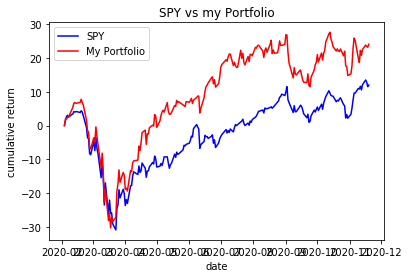

In [59]:
plt.plot(spy.index, spy.kum_ret, "blue", label = "SPY")
plt.plot(spy.index, spy.kum_port_rets, "red", label = "My Portfolio")
plt.legend()
plt.xlabel("date")
plt.ylabel("cumulative return")
plt.title("SPY vs my Portfolio")